# Machine Learning: Landing Success Prediction

## Objective
Build and evaluate machine learning models to predict the probability
of a successful Falcon 9 first-stage landing based on launch
characteristics.

This notebook completes the end-to-end data science pipeline by
transitioning from exploratory analysis to predictive modeling.


In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

import joblib


In [79]:
df = pd.read_csv("../data/processed/spacex_api_clean.csv")
df.shape


(205, 10)

## Feature Selection

Based on EDA insights, the following features are used for prediction:
- Launch site
- Rocket configuration
- Launch year

These features capture operational, temporal, and categorical
characteristics relevant to landing success.


In [80]:
df["launch_year"] = pd.to_datetime(df["launch_date"]).dt.year

# 'rocket' refers to the rocket configuration/name column in the cleaned dataset
features = ["launchpad", "rocket", "launch_year"]
target = "landing_success"

X = df[features]
y = df[target]


In [81]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


## Data Preprocessing

Categorical variables are encoded using one-hot encoding,
while numerical features are standardized.


In [82]:
categorical_features = ["launchpad", "rocket"]
numerical_features = ["launch_year"]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", StandardScaler(), numerical_features)
    ]
)


## Model Training and Evaluation

Multiple classification models are trained and compared to assess
their ability to predict landing success.


In [83]:
log_reg = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(max_iter=1000))
])

log_reg.fit(X_train, y_train)

y_pred_lr = log_reg.predict(X_test)


In [84]:
tree_clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", DecisionTreeClassifier(random_state=42))
])

tree_clf.fit(X_train, y_train)

y_pred_tree = tree_clf.predict(X_test)


In [85]:
rf_clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=100,
        random_state=42
    ))
])

rf_clf.fit(X_train, y_train)

y_pred_rf = rf_clf.predict(X_test)


In [86]:
y_proba_rf = rf_clf.predict_proba(X_test)[:, 1]


In [87]:
roc_auc = roc_auc_score(y_test, y_proba_rf)
roc_auc


0.8250000000000002

In [88]:
def evaluate_model(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1_score": f1_score(y_true, y_pred)
    }


In [89]:
results = pd.DataFrame({
    "Logistic Regression": evaluate_model(y_test, y_pred_lr),
    "Decision Tree": evaluate_model(y_test, y_pred_tree),
    "Random Forest": evaluate_model(y_test, y_pred_rf),
}).T

results


,accuracy,precision,recall,f1_score
Logistic Regression,0.853659,0.875000,0.972222,0.921053
Decision Tree,0.878049,0.897436,0.972222,0.933333
Random Forest,0.878049,0.897436,0.972222,0.933333


In [90]:
# Prepare metrics table for export
metrics_df = (
    results
    .reset_index()
    .rename(columns={"index": "model"})
    .sort_values("f1_score", ascending=False)
)

metrics_df


,model,accuracy,precision,recall,f1_score
1,Decision Tree,0.878049,0.897436,0.972222,0.933333
2,Random Forest,0.878049,0.897436,0.972222,0.933333
0,Logistic Regression,0.853659,0.875000,0.972222,0.921053


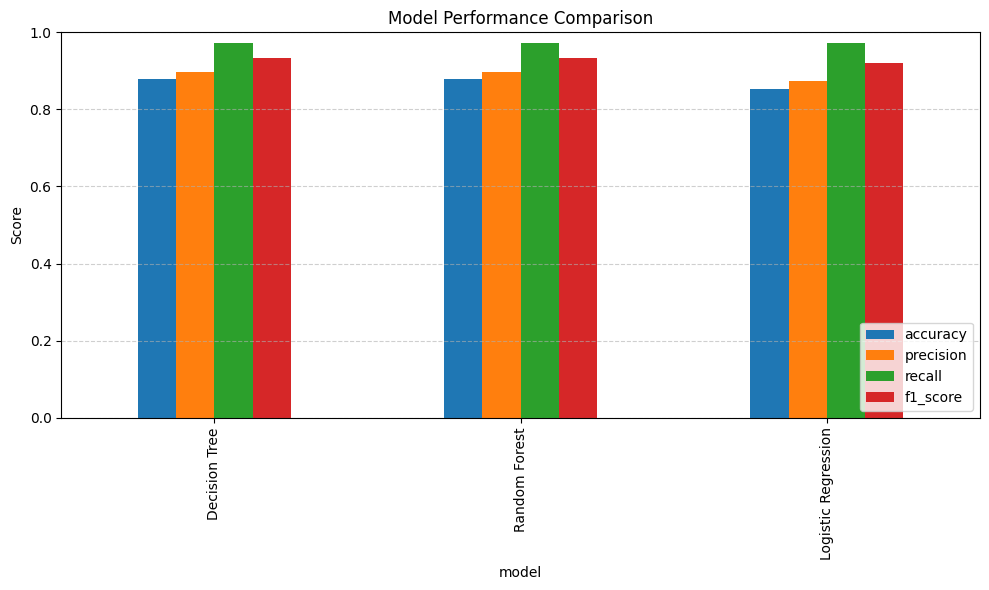

In [91]:
# Plot model comparison
ax = metrics_df.set_index("model")[["accuracy", "precision", "recall", "f1_score"]].plot(
    kind="bar",
    figsize=(10, 6)
)

plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.legend(loc="lower right")

plt.tight_layout()

# Save figure
plt.savefig(
    "../models/metrics/model_comparison.png",
    dpi=150,
    bbox_inches="tight"
)

plt.show()


In [92]:
# Save metrics for portfolio
metrics_df.to_csv("../models/metrics/model_comparison.csv", index=False)


## Confusion Matrix (Best Model)

The confusion matrix provides insight into the types of
classification errors made by the model.


In [93]:
conf_matrix = confusion_matrix(y_test, y_pred_rf)
conf_matrix


array([[ 1,  4],
       [ 1, 35]])

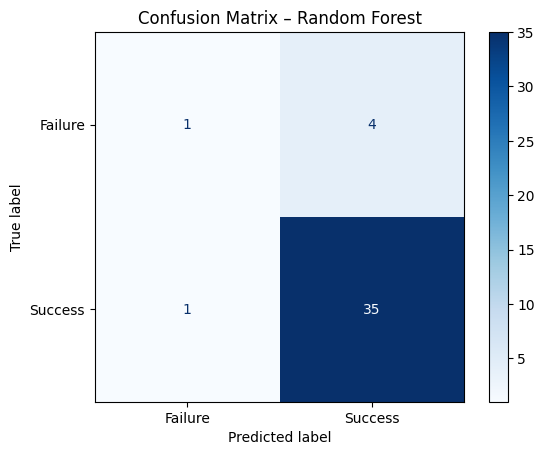

In [94]:
disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix,
    display_labels=["Failure", "Success"]
)

disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix – Random Forest")

plt.savefig(
    "../models/metrics/confusion_matrix_random_forest.png",
    dpi=150,
    bbox_inches="tight"
)

plt.show()


## Model Interpretation

The Random Forest model achieves the best overall performance,
suggesting that non-linear relationships between launch
characteristics and landing success exist.

Temporal trends and launch site differences play a significant
role in predictive performance.


In [95]:
joblib.dump(
    rf_clf,
    "../models/trained_models/random_forest_pipeline.pkl"
)

['../models/trained_models/random_forest_pipeline.pkl']

### Model Inference Example

The trained Random Forest pipeline was successfully reloaded from disk
and used to generate predictions on unseen test data.

The output below represents binary predictions:

- `1` → Successful landing
- `0` → Failed landing

In this example, the model predicts successful landings for all sampled
test observations, which is expected given the strong class imbalance
towards successful outcomes in modern Falcon 9 launches.

In [96]:
# Example: load trained model
loaded_model = joblib.load(
    "../models/trained_models/random_forest_pipeline.pkl"
)

# Example prediction
loaded_model.predict(X_test[:5])

array([1, 1, 1, 1, 1])

### Prediction Probabilities

The model outputs class probabilities, showing the level of confidence
for each prediction.

Some observations receive a probability of 1.0 for successful landing,
indicating unanimous agreement across all trees in the Random Forest.
Others show lower confidence, reflecting more ambiguous launch conditions.

This behavior is expected given the strong historical bias toward
successful Falcon 9 landings and the limited size of the dataset.

In [97]:
# Probability instead of hard classification
loaded_model.predict_proba(X_test[:5])

array([[0.19672691, 0.80327309],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ]])

## Limitations

- The dataset size is relatively limited, which may restrict the model’s ability to generalize to unseen launch configurations.
- Key operational variables such as payload mass, orbit type, and booster reuse count were not included in the modeling process.
- The target variable is derived from historical outcomes and does not account for real-time operational constraints or mission-specific anomalies.
- Model predictions should be interpreted as **probabilistic indicators** rather than deterministic guarantees.

Future improvements could include incorporating additional mission parameters, performing systematic hyperparameter optimization, and evaluating model performance on out-of-sample or future launch data.

---

## Conclusion

This project presents a complete end-to-end data science workflow, covering data collection from multiple sources, data cleaning and feature engineering, exploratory analysis, interactive visualization, and supervised machine learning modeling.

The results demonstrate that Falcon 9 first-stage landing success can be reasonably predicted using launch site, rocket configuration, and temporal features alone. Despite the model’s simplicity, it achieves strong predictive performance, highlighting the value of structured historical launch data and interpretable machine learning pipelines.

This work illustrates how data-driven approaches can support operational decision-making in complex, real-world engineering systems.